# 收益率数据

In [1]:
from zipline.research import returns

In [2]:
assets = ['000001','601118','000333','002024','002273','002030','300159','600771','600649','600866']
# 为同步无风险利率，仅选取一年的数据
start = '2017-01-01'
end = '2018-01-01'

In [3]:
df = returns(assets, start, end)

[2018-05-23 22:27:57.367064] INFO: zipline.finance.metrics.tracker: 模拟1个交易日
首个开盘时间: 2017-12-29 01:31:00+00:00
最后收盘时间: 2017-12-29 07:00:00+00:00


In [4]:
n = len(assets)

In [5]:
# 转换为百分比，而非小数
r = df.multiply(100).values
mu = ((1 + df).cumprod().iloc[-1,:] - 1) * 100

In [6]:
Sigma = df.multiply(100).cov()

In [7]:
Sigma

,平安银行(000001),海南橡胶(601118),美的集团(000333),苏宁易购(002024),水晶光电(002273),达安基因(002030),新研股份(300159),广誉远(600771),城投控股(600649),星湖科技(600866)
平安银行(000001),2.671103,0.466075,0.782444,0.315621,0.170913,0.895665,-0.131870,-0.008981,0.121328,0.071075
海南橡胶(601118),0.466075,3.165573,0.332354,0.769448,1.430423,1.050282,0.468688,0.747894,0.598354,1.269866
美的集团(000333),0.782444,0.332354,3.546529,0.531199,0.451630,0.397212,0.050970,0.456926,0.232359,0.294287
苏宁易购(002024),0.315621,0.769448,0.531199,3.266020,1.229591,1.008920,0.586782,0.784780,0.297031,0.863277
水晶光电(002273),0.170913,1.430423,0.451630,1.229591,6.207008,1.336164,0.753826,1.039226,0.685668,2.337563
达安基因(002030),0.895665,1.050282,0.397212,1.008920,1.336164,4.111830,0.909172,1.076708,0.622564,1.621048
新研股份(300159),-0.131870,0.468688,0.050970,0.586782,0.753826,0.909172,2.484411,0.500198,0.125164,0.972521
广誉远(600771),-0.008981,0.747894,0.456926,0.784780,1.039226,1.076708,0.500198,2.649841,0.540677,0.890689
城投控股(600649),0.121328,0.598354,0.232359,0.297031,0.685668,0.622564,0.125164,0.540677,2.758139,0.975389
星湖科技(600866),0.071075,1.269866,0.294287,0.863277,2.337563,1.621048,0.972521,0.890689,0.975389,3.729393


In [8]:
mu

平安银行(000001)     48.288549
海南橡胶(601118)    -20.258621
美的集团(000333)    102.506211
苏宁易购(002024)      8.062956
水晶光电(002273)     19.123365
达安基因(002030)    -19.733886
新研股份(300159)    -23.326452
广誉远(600771)      21.949761
城投控股(600649)    -56.735497
星湖科技(600866)    -35.028249
Name: 2017-12-29 00:00:00+00:00, dtype: float64

# 马科维茨模型

In [9]:
import numpy as np

In [10]:
# Long only portfolio optimization.
from cvxpy import *
# 投资比例
w = Variable(shape=(n, 1))
# 
gamma = Parameter(nonneg=True)
# 投资组合收益率
ret = mu.values.T * w
risk = quad_form(w, Sigma.values)
# 杠杆为1，且不得有空头头寸
constraints = [sum(w) == 1, w >= 0]
prob = Problem(Maximize(ret - gamma * risk), constraints)

In [11]:
# Compute trade-off curve.
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = sqrt(risk).value
    ret_data[i] = ret.value

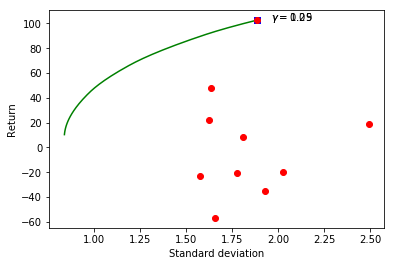

In [12]:
# Plot long only trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline

markers_on = [29, 40]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.08, ret_data[marker]-.03))
for i in range(n):
    plt.plot(sqrt(Sigma.values[i,i]).value, mu.values[i], 'ro')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

在收益率分布下，权衡曲线上标记了两种风险规避值。

请注意，对于低风险值，损失概率接近0，而对于高风险值，损失概率高于0。

**下图好像不正确**

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


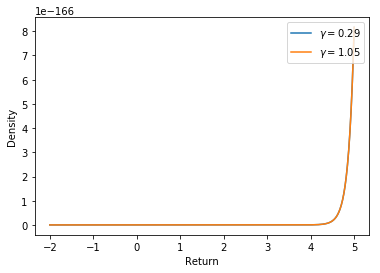

In [13]:
# Plot return distributions for two points on the trade-off curve.
import matplotlib.mlab as mlab
plt.figure()
for midx, idx in enumerate(markers_on):
    gamma.value = gamma_vals[idx]
    prob.solve()
    x = np.linspace(-2, 5, 1000)
    plt.plot(x, mlab.normpdf(x, ret.value, risk.value), label=r"$\gamma = %.2f$" % gamma.value)

plt.xlabel('Return')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

### 投资组合约束

除多头约束外，还有许多其他可能的投资组合约束条件。没有约束(${\cal W} = {\bf R}^n$)，优化问题有一个简单的解析解。我们将详细讨论**leverage limit**，或约束$\|w \|_1 \leq L^\mathrm{max}$。

另一个有趣的约束是**market neutral**，约束$m^T \Sigma w =0$，其中 $m_i$是资产$i$的资本。
$M = m^Tr$是**market return**，以及$m^T \Sigma w = {\bf cov}(M,R)$。

市场中性约束确保投资组合收益与市场收益率无关。

### 举例

在下面的代码中，我们计算并绘制了杠杆限制1,2和4的最优风险收益权衡曲线。

请注意，增大杠杆可以增加收益并允许更大的风险。

In [14]:
# Portfolio optimization with leverage limit.
Lmax = Parameter()
prob = Problem(Maximize(ret - gamma*risk), 
               [sum(w) == 1, 
                norm(w, 1) <= Lmax])

In [15]:
# Compute trade-off curve for each leverage limit.
L_vals = [1, 2, 4]
SAMPLES = 100
risk_data = np.zeros((len(L_vals), SAMPLES))
ret_data = np.zeros((len(L_vals), SAMPLES))
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
w_vals = []
for k, L_val in enumerate(L_vals):
    for i in range(SAMPLES):
        Lmax.value = L_val
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[k, i] = sqrt(risk).value
        ret_data[k, i] = ret.value

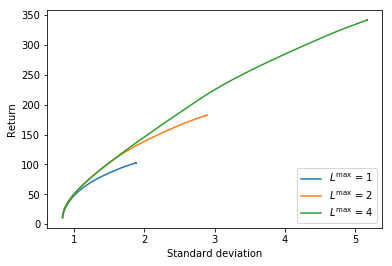

In [16]:
# Plot trade-off curves for each leverage limit.
for idx, L_val in enumerate(L_vals):
    plt.plot(risk_data[idx,:], ret_data[idx,:], label=r"$L^{\max}$ = %d" % L_val)
for w_val in w_vals:
    w.value = w_val
    plt.plot(sqrt(risk).value, ret.value, 'bs')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.legend(loc='lower right')
plt.show()

我们接下来检查$w^T\Sigma w = 2$权衡曲线上的点。

我们将每个资产组合中持有的每项资产的数量绘制为条形图。负数持股表示空头头寸。

注意到一些资产对于低杠杆投资组合持有多头头寸，但在较高杠杆组合中处于空头头寸。

In [17]:
# Portfolio optimization with a leverage limit and a bound on risk.
prob = Problem(Maximize(ret), 
              [sum(w) == 1, 
               norm(w, 1) <= Lmax,
               risk <= 2])

In [18]:
# Compute solution for different leverage limits.
for k, L_val in enumerate(L_vals):
    Lmax.value = L_val
    prob.solve()
    w_vals.append( w.value )

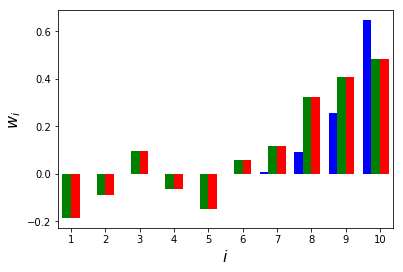

In [19]:
# Plot bar graph of holdings for different leverage limits.
colors = ['b', 'g', 'r']
indices = np.argsort(mu.values.flatten())
for idx, L_val in enumerate(L_vals):
    plt.bar(
        np.arange(1, n + 1) + 0.25 * idx - 0.375,
        w_vals[idx][indices].flatten(),
        color=colors[idx],
        label=r"$L^{\max}$ = %d" % L_val,
        width=0.25)
plt.ylabel(r"$w_i$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.xlim([1 - 0.375, 10 + .375])
plt.xticks(np.arange(1, n + 1))
plt.show()

### 变化

经典的投资组合优化还有更多的变化。 我们可能需要$\mu^T w \geq R^\mathrm{min}$并最小化$w^T \Sigma w$ or $\|\Sigma ^{1/2} w\|_2$。

我们可以将（经纪人）空头头寸的成本包括在内，对那些$s \geq 0$的$s^T (w)_-$的惩罚。

我们可以包括交易成本（来自之前的投资组合$w^\mathrm{prev}$作为惩罚

$$
\kappa ^T |w-w^\mathrm{prev}|^\eta, \quad
\kappa \geq 0.
$$

$\eta$的常见值是$\eta =1, ~ 3/2, ~2$。

### 因子协方差模型

一个特别常见且有用的变化是将协方差矩阵$\Sigma$建模为因子模型
$$
\Sigma  =  F \tilde \Sigma F^T + D,
$$
其中$F \in {\bf R}^{n \times k}$，$k \ll n$是**因子加载矩阵**。$k$是因子（或部门）的数量（通常为10s）。$F_{ij}$是资产$i$到因子$j$的负载。
$D$是一个对角矩阵;$D_{ii}>0$是**特质风险**。$\tilde \Sigma > 0$是**因子协方差矩阵**。

$F^Tw \in {\bf R}^k$给出了投资组合**因子风险敞口**。如果$(F^Tw)_j=0$，则投资组合是*因子$j$中性*。

### 使用因子协方差模型进行投资组合优化

使用因子协方差模型，我们将投资组合优化问题定义为

\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma \left(f^T \tilde \Sigma f  + w^TDw \right) \\
\mbox{subject to} & {\bf 1}^T w = 1, \quad f=F^Tw\\
& w \in {\cal W}, \quad f \in {\cal F},
\end{array}

其中变量是分配比例$w \in {\bf R}^n$和因子风险敞口$f\in {\bf R}^k$，$\cal F$限定因子风险敞口。

在优化问题中使用因子协方差模型具有计算优势。标准问题的求解时间为$O(nk^2)$与$O(n^3)$。

### 例子

在以下代码中，我们生成了有50个因子和3000个资产投资组合优化问题，并与以求解。设置杠杆限制$=2$和$\gamma=0.1$。

我们使用二种方法求解，一种为给定单个矩阵的协方差，另外一种为给定因子模型。用ECOS求解器在CVXPY中单线程运行时，单个矩阵公式的求解时间为687.26秒，因子模型公式的求解时间为0.58秒。机器配置为MacBook Pro，处理器为Intel Core i7。

In [20]:
# Generate data for factor model.
n = 3000
m = 50
np.random.seed(1)
mu = np.abs(np.random.randn(n, 1))
Sigma_tilde = np.random.randn(m, m)
Sigma_tilde = Sigma_tilde.T.dot(Sigma_tilde)
D = np.diag(np.random.uniform(0, 0.9, size=n))
F = np.random.randn(n, m)

In [21]:
# Factor model portfolio optimization.
w = Variable(shape=(n,1))
f = F.T*w
gamma = Parameter(nonneg=True)
Lmax = Parameter()
ret = mu.T*w 
risk = quad_form(f, Sigma_tilde) + quad_form(w, D)
prob_factor = Problem(Maximize(ret - gamma*risk), 
                     [sum(w) == 1, 
                      norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
gamma.value = 0.1
prob_factor.solve(verbose=True)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -7.950e-01  -1.112e+01  +2e+04  9e-01  1e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  -1.203e+01  -1.321e+01  +2e+03  8e-01  2e-02  5e-01  4e-01  0.9890  1e-01   1  1  1 |  0  0
 2  -1.017e+01  -1.030e+01  +2e+02  1e-01  2e-03  5e-03  3e-02  0.9049  8e-04   1  1  1 |  0  0
 3  -6.657e+00  -6.724e+00  +2e+02  6e-02  6e-04  7e-03  3e-02  0.2605  4e-01   1  2  2 |  0  0
 4  -6.355e+00  -6.401e+00  +1e+02  4e-02  4e-04  1e-02  2e-02  0.6410  7e-01   2  2  2 |  0  0
 5  -5.939e+00  -5.971e+00  +1e+02  3e-02  3e-04  8e-03  2e-02  0.3434  4e-01   2  2  2 |  0  0
 6  -6.381e+00  -6.414e+00  +1e+02  3e-02  3e-04  1e-02  2e-02  0.2204  9e-01   2  2  2 |  0  0
 7  -5.583e+00  -5.601e+00  +7e+01  2e-02  2e-04  7e-03  1e-02  0.7038  5e-01   2  2  2 |  0  0
 8  -5.647e+00  -5.664e+00  +7e+01  2e-02  2e-

4.6014667426339155

In [32]:
# Standard portfolio optimization with data from factor model.
risk = quad_form(w, F.dot(Sigma_tilde).dot(F.T) + D)
prob = Problem(Maximize(ret - gamma*risk), 
               [sum(w) == 1, 
                norm(w, 1) <= Lmax])

# Uncomment to solve the problem.
# WARNING: this will take many minutes to run.
# 本机耗时16分钟
prob.solve(verbose=True)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -7.947e-01  -8.986e+00  +2e+05  9e-01  4e-04  1e+00  3e+01    ---    ---    1  1  - |  -  - 
 1  -3.123e+01  -2.907e+01  +3e+04  9e-01  8e-05  4e+00  5e+00  0.9295  1e-01   1  1  1 |  0  0
 2  -2.659e+01  -2.656e+01  +4e+02  4e-02  9e-07  4e-02  6e-02  0.9890  1e-04   1  2  2 |  0  0
 3  -1.515e+01  -1.515e+01  +2e+01  4e-04  1e-08  5e-04  3e-03  0.9890  1e-04   1  3  3 |  0  0
 4  -8.263e+00  -8.262e+00  +7e+00  2e-04  5e-09  4e-04  1e-03  0.5719  1e-01   1  3  3 |  0  0
 5  -8.647e+00  -8.646e+00  +7e+00  2e-04  5e-09  5e-04  1e-03  0.0387  9e-01   2  3  4 |  0  0
 6  -8.989e+00  -8.989e+00  +7e+00  2e-04  5e-09  7e-04  1e-03  0.3018  8e-01   2  4  4 |  0  0
 7  -6.572e+00  -6.572e+00  +4e+00  1e-04  3e-09  6e-04  7e-04  0.6685  4e-01   2  4  4 |  0  0
 8  -6.310e+00  -6.310e+00  +3e+00  8e-05  2e-

4.601466743363137